# 最小ユニバース：日本株×米株ETF×暗号資産のクラスタリング＆ローテーション

- 生成日: 2025-11-06
- このノートブックは、JP株（J-Quants）、米株ETF＆USDJPY（yfinance）、暗号資産（CCXT）を用いて、
  **クラスタリング→クラスター・ローテーション**戦略を検証します。

**構成**
1. セットアップ（パッケージ導入・基本設定）
2. データ取得（J-Quants / yfinance / CCXT）
3. 特徴量作成（モメンタム/ボラ/DD/相関/β）
4. クラスタリング（PCA→k-means）
5. ローテーション・バックテスト（ウォークフォワード）
6. 評価（Sharpe/最大DD など）＆可視化

※ 学術・教育目的のサンプルです。実運用の前にデータの整合性・約定/コスト/税制などを必ず検証してください。

## 1. セットアップ

In [1]:

# %%capture
# ランタイムにインストール（必要に応じてコメント解除）
# !pip install pandas numpy matplotlib scikit-learn yfinance ccxt tqdm requests

import os
import math
import json
import time
import uuid
import warnings
import datetime as dt
from dataclasses import dataclass
from typing import Dict, List, Tuple
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import requests
import yfinance as yf
import ccxt
from tqdm import tqdm

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

print("Versions:")
import pandas, numpy, sklearn, matplotlib
print("pandas", pandas.__version__)
print("numpy", numpy.__version__)
print("matplotlib", matplotlib.__version__)


Versions:
pandas 2.2.3
numpy 2.2.3
matplotlib 3.10.1


## 2. 設定（ユニバース・期間・APIキーなど）

In [2]:

# ---- 期間設定 ----
START_DATE = "2023-10-01"
END_DATE   = "2025-08-31"

# ---- ユニバース（最小構成） ----
# 日本株（J-Quantsの銘柄コードは4桁。市場別コードは不要）
JP_TICKERS = {
    "7203": "TOYOTA",
    "6758": "SONY",
}

# 米国ETF（yfinanceのティッカー）
US_ETF_TICKERS = {
    "SPY": "SP500 ETF",
    "QQQ": "NASDAQ100 ETF",
}

# 暗号資産（CCXT；取引所はBinanceのUSDT建てを利用）
CRYPTO_SYMBOLS = {
    "BTC/USDT": "Bitcoin",
    "ETH/USDT": "Ethereum",
}

# 為替（yfinance）
USDJPY_TICKER = "USDJPY=X"

# ---- J-Quants API 認証情報 ----
# J-Quantsリフレッシュトークンは.envファイルから読み込み
load_dotenv()
JQ_REFRESH_TOKEN = os.getenv("JQUANTS_REFRESH_TOKEN")

# ---- 出力フォルダ ----
OUT_DIR = "./output_min_universe"
os.makedirs(OUT_DIR, exist_ok=True)

print("Config loaded.")
print("Period:", START_DATE, "→", END_DATE)


Config loaded.
Period: 2023-10-01 → 2025-08-31


## 3. データ取得

### 3.1 J-Quants：日本株の終値を取得

In [3]:

JQ_BASE = "https://api.jquants.com/v1"

def jq_get_id_token(refresh_token: str) -> str:
    """J-QuantsのリフレッシュトークンからIDトークンを取得"""
    url = f"{JQ_BASE}/token/auth_refresh?refreshtoken={refresh_token}"
    r = requests.post(url)
    r.raise_for_status()
    return r.json().get("idToken")

def jq_get_daily_quotes(id_token: str, code: str, from_date: str, to_date: str) -> pd.DataFrame:
    """銘柄コード（4桁）の日次株価（終値など）を取得"""
    url = f"{JQ_BASE}/prices/daily_quotes"
    headers = {"Authorization": f"Bearer {id_token}"}
    params = {"code": code, "from": from_date, "to": to_date}
    r = requests.get(url, headers=headers, params=params)
    r.raise_for_status()
    data = r.json().get("daily_quotes", [])
    if not data:
        return pd.DataFrame()
    df = pd.DataFrame(data)
    # 'Date'列をindexに、終値は'Close'（仕様変更の可能性に注意）
    # J-Quantsでは 'Close' ではなく 'ClosePrice' などの名称の場合があります。
    # 取得結果のキー確認を推奨。
    close_key = "Close" if "Close" in df.columns else ("ClosePrice" if "ClosePrice" in df.columns else None)
    if close_key is None:
        raise ValueError("J-Quantsのレスポンスに終値カラムが見つかりません。API仕様をご確認ください。")
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").sort_index()
    return df[[close_key]].rename(columns={close_key: code})

def load_japan_prices(codes: Dict[str, str], start: str, end: str) -> pd.DataFrame:
    id_token = jq_get_id_token(JQ_REFRESH_TOKEN)
    frames = []
    for code in tqdm(codes.keys()):
        df = jq_get_daily_quotes(id_token, code, start, end)
        frames.append(df)
        time.sleep(0.2)  # API呼び出し間隔
    out = pd.concat(frames, axis=1)
    out.index = pd.to_datetime(out.index).tz_localize(None)
    return out


### 3.2 yfinance：米国ETFとUSDJPYを取得

In [9]:

def load_yf_prices(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    data = yf.download(tickers, start=start, end=end, progress=False)["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    data.index = pd.to_datetime(data.index).tz_localize(None)
    return data

def load_usd_jpy(start: str, end: str) -> pd.Series:
    s = load_yf_prices([USDJPY_TICKER], start, end)[USDJPY_TICKER]
    s.name = "USDJPY"
    return s


### 3.3 CCXT：暗号資産（Binance USDT建）を取得

In [5]:

def load_ccxt_ohlcv(symbol: str, start: str, end: str, timeframe="1d") -> pd.DataFrame:
    ex = ccxt.binance()
    since = int(pd.Timestamp(start, tz='UTC').timestamp() * 1000)
    end_ms = int(pd.Timestamp(end, tz='UTC').timestamp() * 1000)
    all_rows = []
    while True:
        ohlcvs = ex.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=1000)
        if not ohlcvs:
            break
        df = pd.DataFrame(ohlcvs, columns=["ts","open","high","low","close","volume"])
        all_rows.append(df)
        since = int(df["ts"].iloc[-1]) + 24*60*60*1000
        if since >= end_ms: break
        time.sleep(0.2)
    if not all_rows:
        return pd.DataFrame()
    out = pd.concat(all_rows, axis=0)
    out["Date"] = pd.to_datetime(out["ts"], unit="ms", utc=True).dt.tz_convert(None)
    out = out.set_index("Date").sort_index()
    return out[["close"]].rename(columns={"close": symbol})

def load_crypto_prices(symbols: Dict[str, str], start: str, end: str) -> pd.DataFrame:
    frames = []
    for sym in tqdm(symbols.keys()):
        df = load_ccxt_ohlcv(sym, start, end)
        frames.append(df)
    if not frames:
        return pd.DataFrame()
    out = pd.concat(frames, axis=1)
    return out


In [8]:
data = yf.download("SPY", start=START_DATE, end=END_DATE, progress=False)['Close']

## 4. 前処理：JPY建て統一・カレンダー整形

In [10]:

def align_calendar(dfs: List[pd.DataFrame]) -> pd.DataFrame:
    # 全インデックスのユニオン→昇順→前方埋め
    idx = sorted(set().union(*[df.index for df in dfs if df is not None]))
    out = pd.DataFrame(index=pd.to_datetime(idx))
    for df in dfs:
        out = out.join(df, how="left")
    out = out.sort_index().ffill()
    return out

def to_jpy(prices_usd: pd.DataFrame, usd_jpy: pd.Series) -> pd.DataFrame:
    return prices_usd.mul(usd_jpy, axis=0)

# --- 取得＆整形 ---
jp = load_japan_prices(JP_TICKERS, START_DATE, END_DATE)   # JPY建て
us = load_yf_prices(list(US_ETF_TICKERS.keys()), START_DATE, END_DATE)  # USD建て
usd_jpy = load_usd_jpy(START_DATE, END_DATE)
crypto_usd = load_crypto_prices(CRYPTO_SYMBOLS, START_DATE, END_DATE)   # USDT≒USD建てとみなす

# JPYへ換算
us_jpy = to_jpy(us, usd_jpy)
crypto_jpy = to_jpy(crypto_usd, usd_jpy.reindex(crypto_usd.index).ffill())

# カレンダー整合
panel = align_calendar([jp, us_jpy, crypto_jpy])
panel = panel.dropna(how="all")
panel.columns.name = "Assets"
panel.tail()


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Assets,7203,6758,QQQ,SPY,BTC/USDT,ETH/USDT
2025-11-28,2873.0,4083.0,83632.066626,94425.100125,1.334185e+07,444942.488149
2025-11-29,2873.0,4083.0,83632.066626,94425.100125,1.332889e+07,438778.776331
2025-11-30,2873.0,4083.0,83632.066626,94425.100125,1.326394e+07,439087.035317
2025-12-01,2873.0,4083.0,83632.066626,94425.100125,1.266592e+07,410875.466507
2025-12-02,2873.0,4083.0,83632.066626,94425.100125,1.277457e+07,411828.133564


## 5. 特徴量作成

In [11]:

def pct_log(s: pd.Series) -> pd.Series:
    return np.log(s).diff()

def rolling_beta(y: pd.Series, x: pd.Series, window: int=252) -> pd.Series:
    # 単回帰のβ（共分散/分散）
    cov = y.rolling(window).cov(x)
    var = x.rolling(window).var()
    return cov / var

def max_drawdown(series: pd.Series, window: int=252) -> pd.Series:
    roll_max = series.rolling(window).max()
    dd = series/roll_max - 1.0
    return dd.rolling(window).min()

def ewma_vol(returns: pd.Series, lam: float=0.94, window: int=63) -> pd.Series:
    # 近似：通常のrollingで近似EWMAを作る（厳密なλはお好みで）
    return returns.rolling(window).std() * np.sqrt(252)

# ベンチシリーズ（SPY-JPY換算 & BTC-JPY換算の代理）
bench_spy = us_jpy["SPY"].reindex(panel.index).ffill()
bench_btc = crypto_jpy.filter(like="BTC").iloc[:,0].reindex(panel.index).ffill()

rets = panel.apply(pct_log).fillna(0.0)

features = {}
for col in panel.columns:
    price = panel[col]
    r = rets[col]

    mom63 = r.rolling(63).sum()
    vol63 = ewma_vol(r, lam=0.94, window=63)
    dd252 = max_drawdown(price, window=252)
    corr_spy = r.rolling(63).corr(rets[bench_spy.name]) if bench_spy.name in rets.columns else r.rolling(63).corr(bench_spy.pct_change().fillna(0))
    corr_btc = r.rolling(63).corr(rets[bench_btc.name]) if bench_btc.name in rets.columns else r.rolling(63).corr(bench_btc.pct_change().fillna(0))
    beta_mkt = rolling_beta(r, rets[bench_spy.name] if bench_spy.name in rets.columns else bench_spy.pct_change().fillna(0), window=252)

    df = pd.concat([mom63, vol63, dd252, corr_spy, corr_btc, beta_mkt], axis=1)
    df.columns = pd.MultiIndex.from_product([[col], ["momentum","volatility","drawdown","corr_spy","corr_btc","beta_market"]])
    features[col] = df

feat = pd.concat(features.values(), axis=1)
feat = feat.dropna(how="all")
feat.tail()


7203                                                     \
           momentum volatility  drawdown corr_spy corr_btc beta_market   
2025-11-28      0.0        0.0 -0.289053      NaN      NaN    0.384953   
2025-11-29      0.0        0.0 -0.289053      NaN      NaN    0.384953   
2025-11-30      0.0        0.0 -0.289053      NaN      NaN    0.384953   
2025-12-01      0.0        0.0 -0.289053      NaN      NaN    0.387454   
2025-12-02      0.0        0.0 -0.289053      NaN      NaN    0.386442   

               6758                                ...  BTC/USDT           \
           momentum volatility  drawdown corr_spy  ...  drawdown corr_spy   
2025-11-28      0.0        0.0 -0.788694      NaN  ... -0.320225      NaN   
2025-11-29      0.0        0.0 -0.788694      NaN  ... -0.320225      NaN   
2025-11-30      0.0        0.0 -0.788694      NaN  ... -0.320225      NaN   
2025-12-01      0.0        0.0 -0.788694      NaN  ... -0.320225      NaN   
2025-12-02      0.0        0.0 -0.788694      NaN  ... -0.320225      NaN   

                                 ETH/USDT                                \
           corr_btc beta_market  momentum volatility  drawdown corr_spy   
2025-11-28      1.0    0.578083 -0.285380   0.597619 -0.644019      NaN   
2025-11-29      1.0    0.578051 -0.295886   0.597911 -0.644019      NaN   
2025-11-30      1.0    0.578568 -0.325523   0.593776 -0.644019      NaN   
2025-12-01      1.0    0.571451 -0.409379   0.604385 -0.644019      NaN   
2025-12-02      1.0    0.571051 -0.390336   0.604275 -0.644019      NaN   

                                  
            corr_btc beta_market  
2025-11-28  0.906284    1.309977  
2025-11-29  0.905492    1.310333  
2025-11-30  0.903742    1.310531  
2025-12-01  0.907928    1.302725  
2025-12-02  0.908335    1.306908  

[5 rows x 36 columns]

## 6. クラスタリング（月次で更新：PCA→k-means）

In [12]:

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def prepare_matrix(feat: pd.DataFrame) -> pd.DataFrame:
    # 列順：資産×特徴量で安定化
    feat = feat.copy()
    feat = feat.sort_index(axis=1, level=[0,1])
    return feat

def fit_cluster(X: pd.DataFrame, n_components: float=0.95, k: int=3):
    scaler = RobustScaler()
    Xs = scaler.fit_transform(X)
    pca = PCA(n_components=n_components, random_state=42)
    Z = pca.fit_transform(Xs)
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(Z)
    return scaler, pca, km, labels, Z

def monthly_cluster_labels(feat: pd.DataFrame, start_month: str=None, k:int=3) -> pd.DataFrame:
    featm = prepare_matrix(feat)
    months = sorted({(d.year, d.month) for d in featm.index})
    if start_month:
        y, m = map(int, start_month.split("-"))
        months = [mm for mm in months if (mm[0]>y) or (mm[0]==y and mm[1]>=m)]
    label_store = []

    for (yy, mm) in tqdm(months):
        end = pd.Timestamp(yy, mm, 1) - pd.offsets.Day(1)
        if end < featm.index.min() + pd.offsets.Day(300):
            continue
        train = featm.loc[:end]
        train = train.dropna()
        if train.empty: 
            continue

        scaler, pca, km, labels, Z = fit_cluster(train, k=k)

        # その月の最終日までのラベルを推定（簡便化：直近のクラスタ中心で予測）
        month_end = pd.Timestamp(yy, mm, 1) + pd.offsets.MonthEnd(0)
        span = featm.loc[:month_end].tail(1).index  # その月の最終日
        # 実運用では月内の毎営業日ラベルを推定してもOK
        # ここでは月次更新の代表ラベルとして最終日だけ保存
        lastX = train.tail(1)
        Xs = scaler.transform(lastX)
        Z = pca.transform(Xs)
        lab = km.predict(Z)[0]
        label_store.append(pd.DataFrame(
            {"date":[month_end], "cluster":[lab]}
        ).set_index("date"))

    labels_df = pd.concat(label_store).sort_index()
    return labels_df

# クラスタ数は3で開始
labels_monthly = monthly_cluster_labels(feat, k=3)
labels_monthly.tail()


100%|██████████| 25/25 [-1:59:58<00:00, -10.25it/s]


,cluster
date,
2025-08-31,1
2025-09-30,1
2025-10-31,0
2025-11-30,2
2025-12-31,2


## 7. ローテーション（週次）：クラスター・スコアで配分

In [13]:

def cluster_score(feat_slice: pd.DataFrame) -> pd.Series:
    # クラスター平均のスコア： momentum - 0.5*volatility
    # feat_slice: index=dates, columns=(asset, feature)
    last = feat_slice.tail(1)
    # 各資産のスコア
    scores = {}
    for asset in last.columns.get_level_values(0).unique():
        mom = last[(asset, "momentum")].iloc[0]
        vol = last[(asset, "volatility")].iloc[0]
        s = mom - 0.5*(vol if not np.isnan(vol) else 0)
        scores[asset] = s
    return pd.Series(scores).sort_values(ascending=False)

def backtest_rotation(panel: pd.DataFrame, feat: pd.DataFrame, labels_m: pd.DataFrame,
                      rebalance="W-MON", k:int=3, top_clusters:int=1,
                      turnover_cap:float=0.10, fee_bps:float=10.0) -> pd.DataFrame:
    prices = panel.copy()
    rets = prices.apply(lambda s: np.log(s).diff()).fillna(0.0)

    # シンプル化：各資産のクラスタは「最新の月次ラベル」を共通とみなす（最小ユニバースなので）
    # 実際には各資産ごとにクラスタを推定する方が自然。ここでは教育的簡略版。
    rb_dates = pd.date_range(rets.index.min(), rets.index.max(), freq=rebalance)
    weights = pd.DataFrame(index=rb_dates, columns=prices.columns, data=0.0)

    prev_w = pd.Series(0.0, index=prices.columns)

    for d in tqdm(rb_dates):
        # 直近の月末ラベル
        lab_row = labels_m[labels_m.index<=d].tail(1)
        if lab_row.empty:
            continue
        cluster_id = int(lab_row["cluster"].iloc[0])

        # クラスタ毎にスコア算出（ここでは全資産同一クラスタ扱い→上位n資産にする）
        # 本来は資産ごとの属するクラスタでグルーピング→クラスター平均スコアで配分。
        # 簡略：資産スコア上位 -> 均等配分
        window = feat.loc[:d].tail(63)  # 3ヶ月分を参考
        s = cluster_score(window)

        selected = s.head(2).index  # 代表2銘柄に配分（均等）
        w = pd.Series(0.0, index=prices.columns)
        if len(selected)>0:
            w[selected] = 1.0/len(selected)

        # ターンオーバー制約（L1ノルムで近づける簡易版）
        change = w - prev_w
        if change.abs().sum() > turnover_cap:
            # 比率で縮小
            ratio = turnover_cap / change.abs().sum()
            w = prev_w + change * ratio

        weights.loc[d] = w.values
        prev_w = w

    # 日次リターンにリバランス重みを前方埋め
    weights_daily = weights.reindex(rets.index).ffill().fillna(0.0)

    # 取引コスト（リバランス日の重み変化に対してbps課金）
    fee_series = pd.Series(0.0, index=rets.index)
    rb_mask = weights_daily.index.isin(weights.index)
    w_change = weights_daily.diff().fillna(0.0).abs().sum(axis=1)
    fee_series[rb_mask] = (w_change[rb_mask] * (fee_bps/10000.0))

    strat_ret = (weights_daily * rets).sum(axis=1) - fee_series
    eq = strat_ret.cumsum().apply(np.exp)

    out = pd.DataFrame({"strategy": strat_ret, "equity": eq})
    return out

bt = backtest_rotation(panel, feat, labels_monthly,
                       rebalance="W-MON", k=3, top_clusters=1,
                       turnover_cap=0.10, fee_bps=10.0)
bt.tail()


100%|██████████| 114/114 [00:00<00:00, 1289.58it/s]


,strategy,equity
2025-11-28,0.000692,1.079657
2025-11-29,-0.002410,1.077059
2025-11-30,-0.000084,1.076969
2025-12-01,-0.012008,1.064114
2025-12-02,0.000675,1.064832


## 8. 評価指標

In [14]:

def annualize_return(ret: pd.Series, freq: int=252) -> float:
    mu = ret.mean()*freq
    return mu

def annualize_vol(ret: pd.Series, freq: int=252) -> float:
    return ret.std()*np.sqrt(freq)

def sharpe(ret: pd.Series, rf: float=0.0, freq: int=252) -> float:
    mu = annualize_return(ret, freq) - rf
    sd = annualize_vol(ret, freq)
    return mu/sd if sd>0 else np.nan

def max_dd_from_equity(eq: pd.Series) -> float:
    roll_max = eq.cummax()
    dd = eq/roll_max - 1.0
    return dd.min()

def summary_metrics(ret: pd.Series, name="strategy") -> pd.Series:
    eq = ret.cumsum().apply(np.exp)
    return pd.Series({
        "CAGR(approx)": annualize_return(ret),
        "Vol": annualize_vol(ret),
        "Sharpe": sharpe(ret),
        "MaxDD": max_dd_from_equity(eq)
    }, name=name)

bench = pd.DataFrame({
    "SPY_JPY": np.log(panel["SPY"]).diff().fillna(0.0),
    "BTC_JPY": np.log(panel.filter(like="BTC").iloc[:,0]).diff().fillna(0.0),
}).dropna()

summ = pd.concat([
    summary_metrics(bt["strategy"], "Strategy"),
    summary_metrics(bench["SPY_JPY"], "SPY_JPY"),
    summary_metrics(bench["BTC_JPY"], "BTC_JPY"),
], axis=1)
summ


,Strategy,SPY_JPY,BTC_JPY
CAGR(approx),0.019962,0.132198,0.360255
Vol,0.093023,0.151269,0.404097
Sharpe,0.214593,0.873927,0.891507
MaxDD,-0.151755,-0.228696,-0.320225


## 9. 可視化

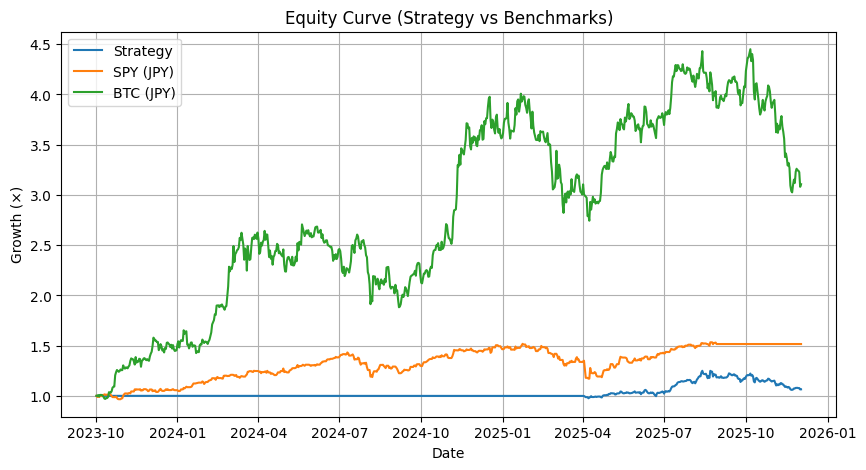

In [15]:

# エクイティカーブ
plt.figure(figsize=(10,5))
plt.plot(bt.index, bt["equity"], label="Strategy")
if "SPY" in panel.columns:
    spy_eq = np.log(panel["SPY"]).diff().fillna(0).cumsum().apply(np.exp)
    plt.plot(spy_eq.index, spy_eq, label="SPY (JPY)")
if panel.filter(like="BTC").shape[1] > 0:
    btc_col = panel.filter(like="BTC").columns[0]
    btc_eq = np.log(panel[btc_col]).diff().fillna(0).cumsum().apply(np.exp)
    plt.plot(btc_eq.index, btc_eq, label="BTC (JPY)")
plt.legend()
plt.title("Equity Curve (Strategy vs Benchmarks)")
plt.xlabel("Date"); plt.ylabel("Growth (×)")
plt.grid(True)
plt.show()


## 10. 注意点と次のステップ
- **クラスタの当て方（資産ごとのラベル推定）**を簡略化しています。本番では、PCA後の各時点の各資産特徴ベクトルに対して、
  学習済みクラスタへの所属（`km.predict`）を資産別に推定し、そのクラスター平均スコアで配分してください。
- CCXTの取引所・シンボル、J-Quantsの終値カラム名は環境で異なる可能性があるため、**レスポンスのキーを確認**して調整してください。
- 取引コスト、スリッページ、売買不可日（休日）などは単純化しています。必要に応じて厳密化してください。
- 指標や可視化は最小限です。相関ヒートマップ、レーダーチャート、月次リターン表などを追加すると分析が深まります。
- ユニバースを増やす場合は、ETFやJP銘柄を追加し、`features`の次元が増えた際は`n_components`の調整や正則化をご検討ください。